## Data Loading and Overview

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans, DBSCAN
from sklearn.cluster import AgglomerativeClustering
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import dendrogram, linkage
import warnings
warnings.filterwarnings('ignore')

In [18]:
raw_data = pd.read_csv("marketing_campaign.csv", delimiter="\t")
df = raw_data.copy()
pd.set_option("display.max_columns", None)
df.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,49,127,111,21,42,1,8,2,10,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,4,20,10,3,5,2,2,0,4,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,43,118,46,27,15,5,5,3,6,5,0,0,0,0,0,0,3,11,0


In [19]:
#no duplicate values, income has null values - imputing with median as income is right-skewed
df['Income']=df['Income'].fillna(df['Income'].median())

#dropping ID, and Z_CostContact & Z_Revenue (similar values in all entries)
df.drop(['ID','Z_CostContact','Z_Revenue'], axis=1, inplace=True)

#converting Dt_Customer to datetime objects for analysis
df["Dt_Customer"] = pd.to_datetime(df["Dt_Customer"], dayfirst=True)

#extracted feature 'Age' by subtracting the latest customer enrollment date with their Birth year
df['Age'] = df['Dt_Customer'].max().year - df['Year_Birth']
df.drop(['Year_Birth'], axis=1, inplace=True) #don't need it anymore

#defining bins and labels for age
age_bins = [17, 25, 45, 65, 100]  # cut-off points
age_labels = [
    "Young Impulsive/Luxury (18–25)",
    "Budget-Conscious (26–45)",
    "Affluent Mid-Lifers (46–65)",
    "Senior Premium Buyers (65+)"
]
# Apply binning
df['AgeGroup'] = pd.cut(df['Age'], bins=age_bins, labels=age_labels)
df.drop(['Age'], axis=1, inplace=True)

#extracted children at home from number of kids and teens at home of a buyer
df['Children'] = df['Kidhome'] + df['Teenhome']
df.drop(['Kidhome','Teenhome'], axis=1, inplace=True) #don't need it anymore

#binary encode
df['Is_In_Relationship'] = df['Marital_Status'].isin(['Married', 'Together']).astype(int)
df['Is_Single'] = df['Marital_Status'].isin(['Single','Divorced','Widow','Alone','Absurd','YOLO']).astype(int)
df.drop(['Marital_Status'], axis=1, inplace=True) #don't need it anymore

df['Expenses'] = (df['MntWines'] + df['MntFruits'] + df['MntMeatProducts'] + df['MntFishProducts'] + df['MntSweetProducts'] + df['MntGoldProds'])
df.drop(['MntWines','MntFruits','MntMeatProducts','MntFishProducts','MntSweetProducts','MntGoldProds'], axis=1, inplace=True) #don't need it anymore

df['Effective_Campaigns'] = (df['AcceptedCmp1'] + df['AcceptedCmp2'] + df['AcceptedCmp3'] + df['AcceptedCmp4'] + df['AcceptedCmp5'])
df.drop(['AcceptedCmp1','AcceptedCmp2','AcceptedCmp3','AcceptedCmp4','AcceptedCmp5'], axis=1, inplace=True) #don't need it anymore

df['Total_Purchases'] = (df['NumWebPurchases'] + df['NumCatalogPurchases'] + df['NumStorePurchases'])
df.drop(['NumWebPurchases','NumCatalogPurchases','NumStorePurchases'], axis=1, inplace=True) #don't need it anymore

# binning education in 3 categories based on their expenditure and accepted campaigns
df['Education'] = df['Education'].replace(['PhD', 'Master', "Graduation"], "Graduated")
#Label encoding education
le_education = LabelEncoder()
df['Education_Encoded'] = le_education.fit_transform(df['Education'])

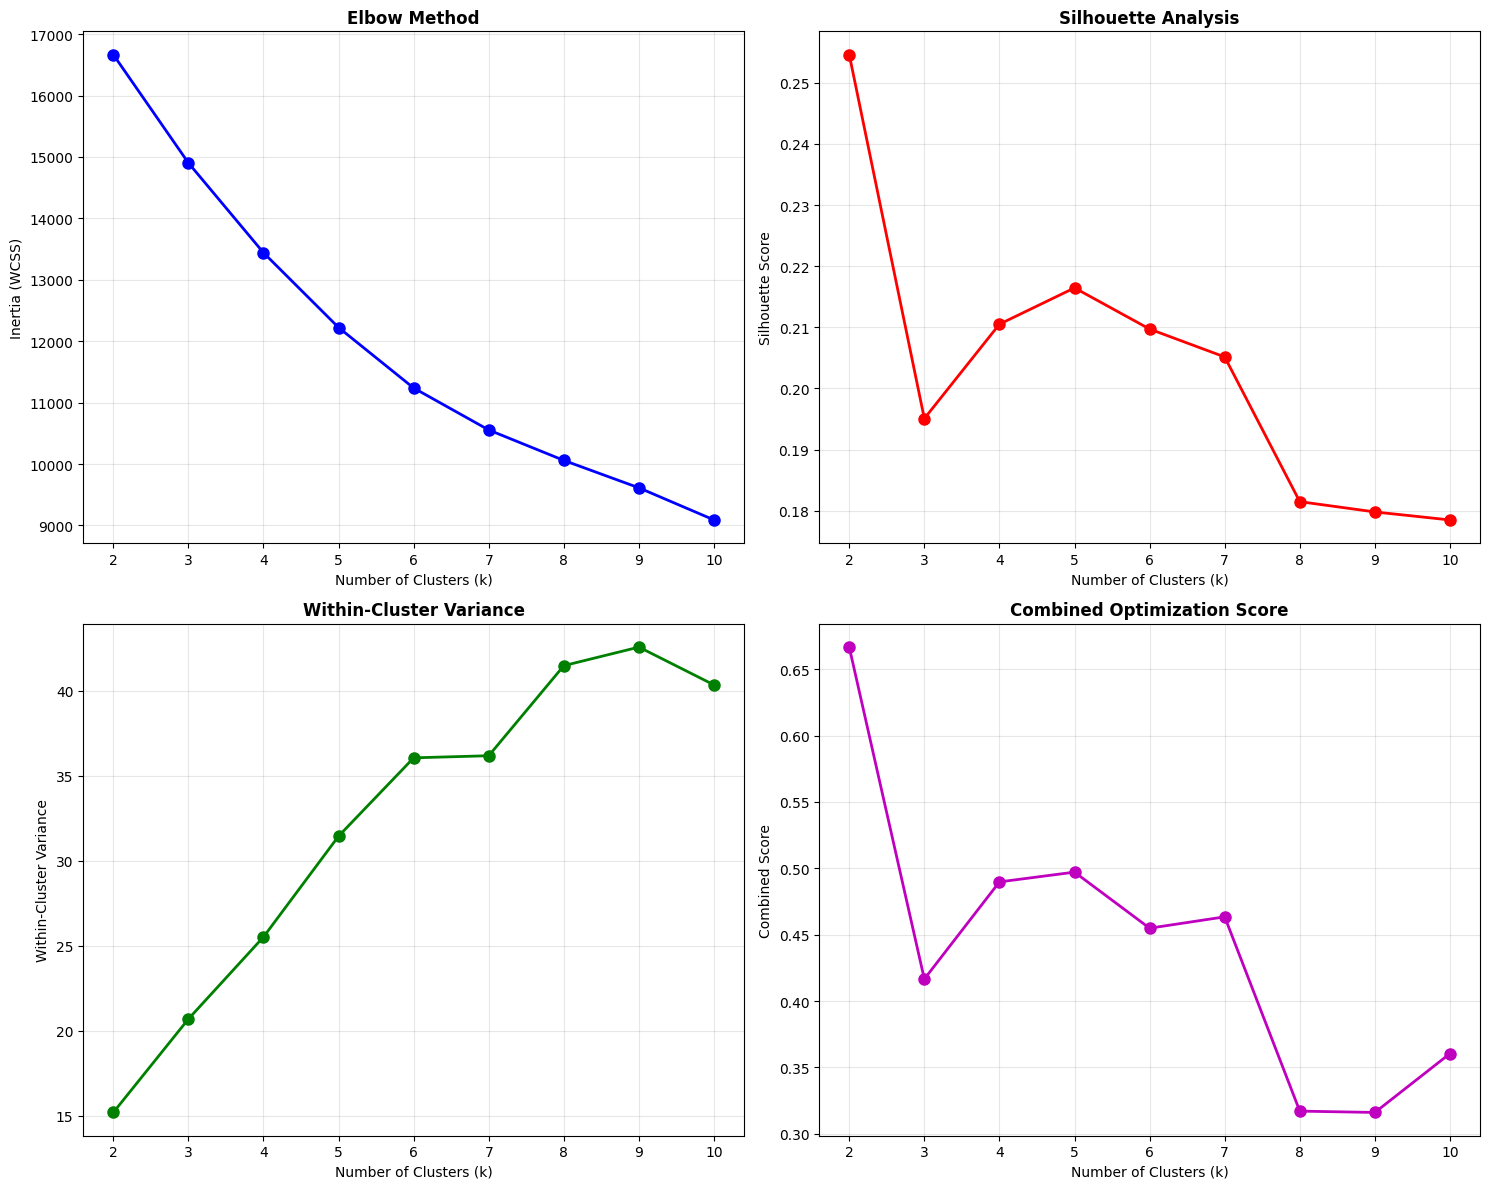

CLUSTER EVALUATION RESULTS:
k=2: Silhouette=0.255, Inertia=16667, WCV=15.20, Combined=0.667
k=3: Silhouette=0.195, Inertia=14904, WCV=20.70, Combined=0.417
k=4: Silhouette=0.211, Inertia=13441, WCV=25.52, Combined=0.490
k=5: Silhouette=0.216, Inertia=12223, WCV=31.45, Combined=0.497
k=6: Silhouette=0.210, Inertia=11238, WCV=36.06, Combined=0.455
k=7: Silhouette=0.205, Inertia=10555, WCV=36.18, Combined=0.463
k=8: Silhouette=0.181, Inertia=10059, WCV=41.48, Combined=0.317
k=9: Silhouette=0.180, Inertia=9613, WCV=42.57, Combined=0.316
k=10: Silhouette=0.178, Inertia=9090, WCV=40.35, Combined=0.360

Recommended k based on silhouette score: 2
Recommended k based on combined score: 2

Selected optimal number of clusters: 2

=== APPLYING CLUSTERING ALGORITHMS ===
K-Means Results:
  Clusters: (array([0, 1], dtype=int32), array([1331,  909]))
  Silhouette Score: 0.255
  Inertia: 16667

Hierarchical Results:
  Clusters: (array([0, 1]), array([1441,  799]))
  Silhouette Score: 0.213

DBSCAN Resu

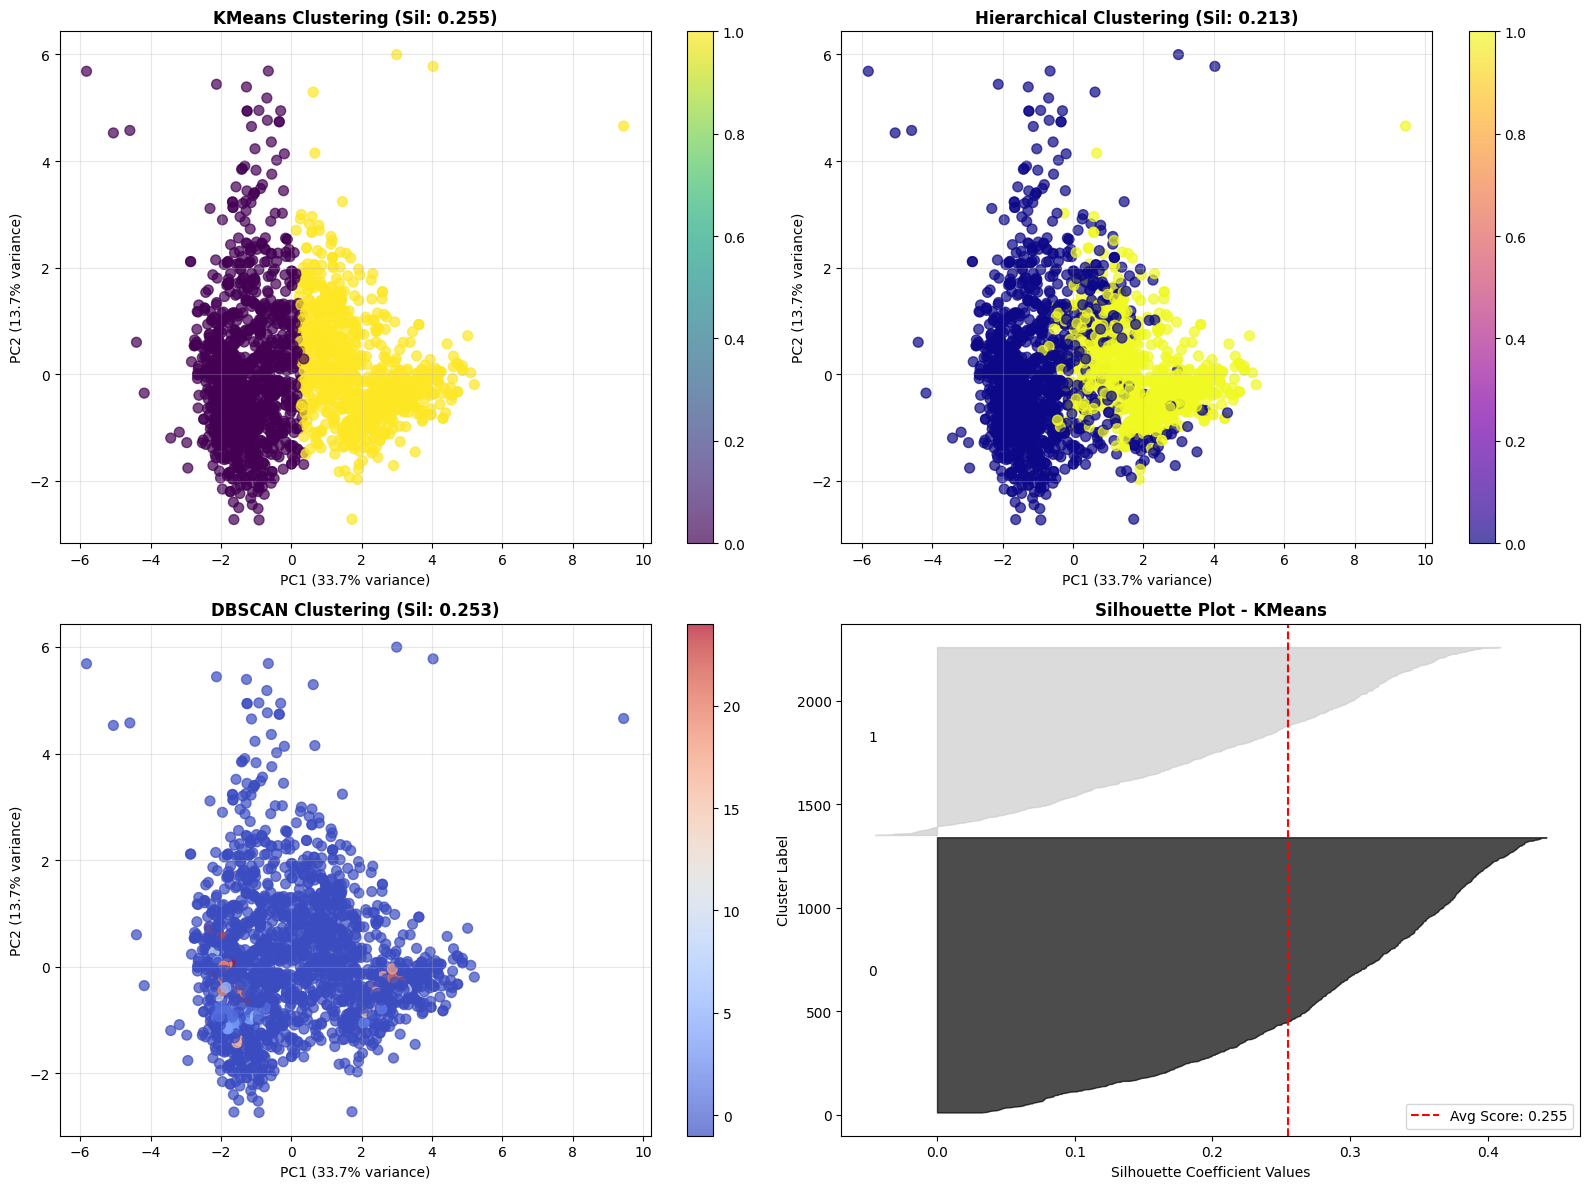

PCA explained variance ratio: PC1=33.7%, PC2=13.7%


In [20]:
# SELECT FEATURES FOR CLUSTERING
# Select numerical features for clustering (excluding categorical and encoded features)
clustering_features = ['Income', 'Recency', 'NumDealsPurchases', 'NumWebVisitsMonth', 'Children', 'Expenses', 'Effective_Campaigns', 'Total_Purchases', 'Is_In_Relationship', 'Education_Encoded']

X = df[clustering_features].copy()

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=clustering_features)

# 2. ENHANCED UNSUPERVISED CLUSTERING

# FINDING OPTIMAL NUMBER OF CLUSTERS WITH MULTIPLE METRICS
# Multiple metrics for optimal K selection
K_range = range(2, 11)
inertias = []
silhouette_scores = []
within_cluster_variances = []

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)

    # Inertia (WCSS)
    inertias.append(kmeans.inertia_)

    # Silhouette Score
    sil_score = silhouette_score(X_scaled, labels)
    silhouette_scores.append(sil_score)

    # Within-cluster variance (sum of cluster variances)
    wcv = 0
    for cluster_id in range(k):
        cluster_points = X_scaled[labels == cluster_id]
        if len(cluster_points) > 1:
            wcv += np.var(cluster_points, axis=0).sum()
    within_cluster_variances.append(wcv)

# Plot comprehensive evaluation metrics
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Elbow curve
axes[0,0].plot(K_range, inertias, 'bo-', linewidth=2, markersize=8)
axes[0,0].set_xlabel('Number of Clusters (k)')
axes[0,0].set_ylabel('Inertia (WCSS)')
axes[0,0].set_title('Elbow Method', fontweight='bold')
axes[0,0].grid(True, alpha=0.3)
axes[0,0].set_xticks(K_range)

# Silhouette scores
axes[0,1].plot(K_range, silhouette_scores, 'ro-', linewidth=2, markersize=8)
axes[0,1].set_xlabel('Number of Clusters (k)')
axes[0,1].set_ylabel('Silhouette Score')
axes[0,1].set_title('Silhouette Analysis', fontweight='bold')
axes[0,1].grid(True, alpha=0.3)
axes[0,1].set_xticks(K_range)

# Within-cluster variance
axes[1,0].plot(K_range, within_cluster_variances, 'go-', linewidth=2, markersize=8)
axes[1,0].set_xlabel('Number of Clusters (k)')
axes[1,0].set_ylabel('Within-Cluster Variance')
axes[1,0].set_title('Within-Cluster Variance', fontweight='bold')
axes[1,0].grid(True, alpha=0.3)
axes[1,0].set_xticks(K_range)

# Combined score (normalized)
# Normalize metrics to 0-1 scale for combination
norm_sil = (np.array(silhouette_scores) - min(silhouette_scores)) / (max(silhouette_scores) - min(silhouette_scores))
norm_inertia = 1 - (np.array(inertias) - min(inertias)) / (max(inertias) - min(inertias))  # Invert because lower is better
norm_wcv = 1 - (np.array(within_cluster_variances) - min(within_cluster_variances)) / (max(within_cluster_variances) - min(within_cluster_variances))  # Invert

combined_score = (norm_sil + norm_inertia + norm_wcv) / 3

axes[1,1].plot(K_range, combined_score, 'mo-', linewidth=2, markersize=8)
axes[1,1].set_xlabel('Number of Clusters (k)')
axes[1,1].set_ylabel('Combined Score')
axes[1,1].set_title('Combined Optimization Score', fontweight='bold')
axes[1,1].grid(True, alpha=0.3)
axes[1,1].set_xticks(K_range)

plt.tight_layout()
plt.show()

# Find optimal k based on silhouette score
optimal_k_sil = K_range[np.argmax(silhouette_scores)]
optimal_k_combined = K_range[np.argmax(combined_score)]

print("CLUSTER EVALUATION RESULTS:")
print("="*40)
for i, k in enumerate(K_range):
    print(f"k={k}: Silhouette={silhouette_scores[i]:.3f}, "
          f"Inertia={inertias[i]:.0f}, WCV={within_cluster_variances[i]:.2f}, "
          f"Combined={combined_score[i]:.3f}")

print(f"\nRecommended k based on silhouette score: {optimal_k_sil}")
print(f"Recommended k based on combined score: {optimal_k_combined}")

# Set optimal k
optimal_k = optimal_k_sil
print(f"\nSelected optimal number of clusters: {optimal_k}")

print("\n=== APPLYING CLUSTERING ALGORITHMS ===")

# 1. K-Means Clustering
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(X_scaled)

# Calculate detailed metrics for K-Means
kmeans_silhouette = silhouette_score(X_scaled, kmeans_labels)
kmeans_inertia = kmeans.inertia_

print(f"K-Means Results:")
print(f"  Clusters: {np.unique(kmeans_labels, return_counts=True)}")
print(f"  Silhouette Score: {kmeans_silhouette:.3f}")
print(f"  Inertia: {kmeans_inertia:.0f}")

# 2. Hierarchical Clustering
hierarchical = AgglomerativeClustering(n_clusters=optimal_k)
hierarchical_labels = hierarchical.fit_predict(X_scaled)
hierarchical_silhouette = silhouette_score(X_scaled, hierarchical_labels)

print(f"\nHierarchical Results:")
print(f"  Clusters: {np.unique(hierarchical_labels, return_counts=True)}")
print(f"  Silhouette Score: {hierarchical_silhouette:.3f}")

# 3. DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(X_scaled)

# Only calculate silhouette if we have more than 1 cluster and no all-noise scenario
if len(np.unique(dbscan_labels)) > 1 and not np.all(dbscan_labels == -1):
    # Exclude noise points for silhouette calculation
    mask = dbscan_labels != -1
    if np.sum(mask) > 1:
        dbscan_silhouette = silhouette_score(X_scaled[mask], dbscan_labels[mask])
    else:
        dbscan_silhouette = -1  # Cannot calculate
else:
    dbscan_silhouette = -1  # Cannot calculate

print(f"\nDBSCAN Results:")
print(f"  Clusters: {np.unique(dbscan_labels, return_counts=True)} (including noise: -1)")
print(f"  Silhouette Score: {dbscan_silhouette:.3f}" if dbscan_silhouette != -1 else "  Silhouette Score: Cannot calculate (insufficient clusters)")

# Store results with metrics
clustering_results = {
    'KMeans': {'labels': kmeans_labels, 'silhouette': kmeans_silhouette},
    'Hierarchical': {'labels': hierarchical_labels, 'silhouette': hierarchical_silhouette},
    'DBSCAN': {'labels': dbscan_labels, 'silhouette': dbscan_silhouette}
}

# Choose best algorithm based on silhouette score
best_method = max(clustering_results.keys(),
                 key=lambda x: clustering_results[x]['silhouette'] if clustering_results[x]['silhouette'] != -1 else -2)
best_labels = clustering_results[best_method]['labels']
best_silhouette = clustering_results[best_method]['silhouette']

print(f"\nBest performing algorithm: {best_method} (Silhouette: {best_silhouette:.3f})")

print("\n=== VISUALIZING CLUSTERS ===")

# PCA for 2D visualization
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

# Create subplots for all three methods
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.ravel()

colors = ['viridis', 'plasma', 'coolwarm']
for idx, (method, result) in enumerate(clustering_results.items()):
    labels = result['labels']
    silhouette = result['silhouette']

    scatter = axes[idx].scatter(X_pca[:, 0], X_pca[:, 1], c=labels,
                              cmap=colors[idx], alpha=0.7, s=50)
    title = f'{method} Clustering'
    if silhouette != -1:
        title += f' (Sil: {silhouette:.3f})'
    axes[idx].set_title(title, fontsize=12, fontweight='bold')
    axes[idx].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
    axes[idx].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
    plt.colorbar(scatter, ax=axes[idx])
    axes[idx].grid(True, alpha=0.3)

# Silhouette plot for best method
sample_silhouette_values = silhouette_samples(X_scaled, best_labels)

axes[3].set_title(f'Silhouette Plot - {best_method}', fontweight='bold')
y_lower = 10

colors = plt.cm.nipy_spectral(np.linspace(0, 1, len(np.unique(best_labels))))
for i, color in zip(np.unique(best_labels), colors):
    if i == -1:  # Skip noise points for DBSCAN
        continue
    cluster_silhouette_values = sample_silhouette_values[best_labels == i]
    cluster_silhouette_values.sort()

    size_cluster_i = cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    axes[3].fill_betweenx(np.arange(y_lower, y_upper), 0, cluster_silhouette_values,
                         facecolor=color, edgecolor=color, alpha=0.7)
    axes[3].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
    y_lower = y_upper + 10

axes[3].axvline(x=best_silhouette, color="red", linestyle="--",
               label=f'Avg Score: {best_silhouette:.3f}')
axes[3].set_xlabel('Silhouette Coefficient Values')
axes[3].set_ylabel('Cluster Label')
axes[3].legend()

plt.tight_layout()
plt.show()

print(f"PCA explained variance ratio: PC1={pca.explained_variance_ratio_[0]:.1%}, PC2={pca.explained_variance_ratio_[1]:.1%}")



=== CLUSTER PROFILING (Using KMeans Results) ===
Detailed Cluster Profiles:
   Cluster  Size  Size_Percent  Avg_Income  Avg_Expenses  Avg_Total_Purchases  \
0        0  1331         59.42    38347.12        193.44                 7.80   
1        1   909         40.58    72577.61       1209.59                19.48   

   Avg_Children  Avg_Recency  Avg_Campaigns  Avg_Web_Visits  \
0          1.27        49.06           0.11            6.51   
1          0.48        49.19           0.58            3.57   

   Avg_Deal_Purchases  Relationship_Rate  Response_Rate  Education_Level  
0                2.66               0.65           0.10             1.75  
1                1.83               0.63           0.22             1.85  

=== CLUSTER STABILITY ANALYSIS ===
Within-Cluster Variance Analysis:
Cluster 0:
  Total Variance: 6.755
  Average Variance: 0.675
  Max Feature Variance: 1.149
  Most Variable Features: NumDealsPurchases(1.149), Education_Encoded(1.137), Recency(1.001)

Cluster 1

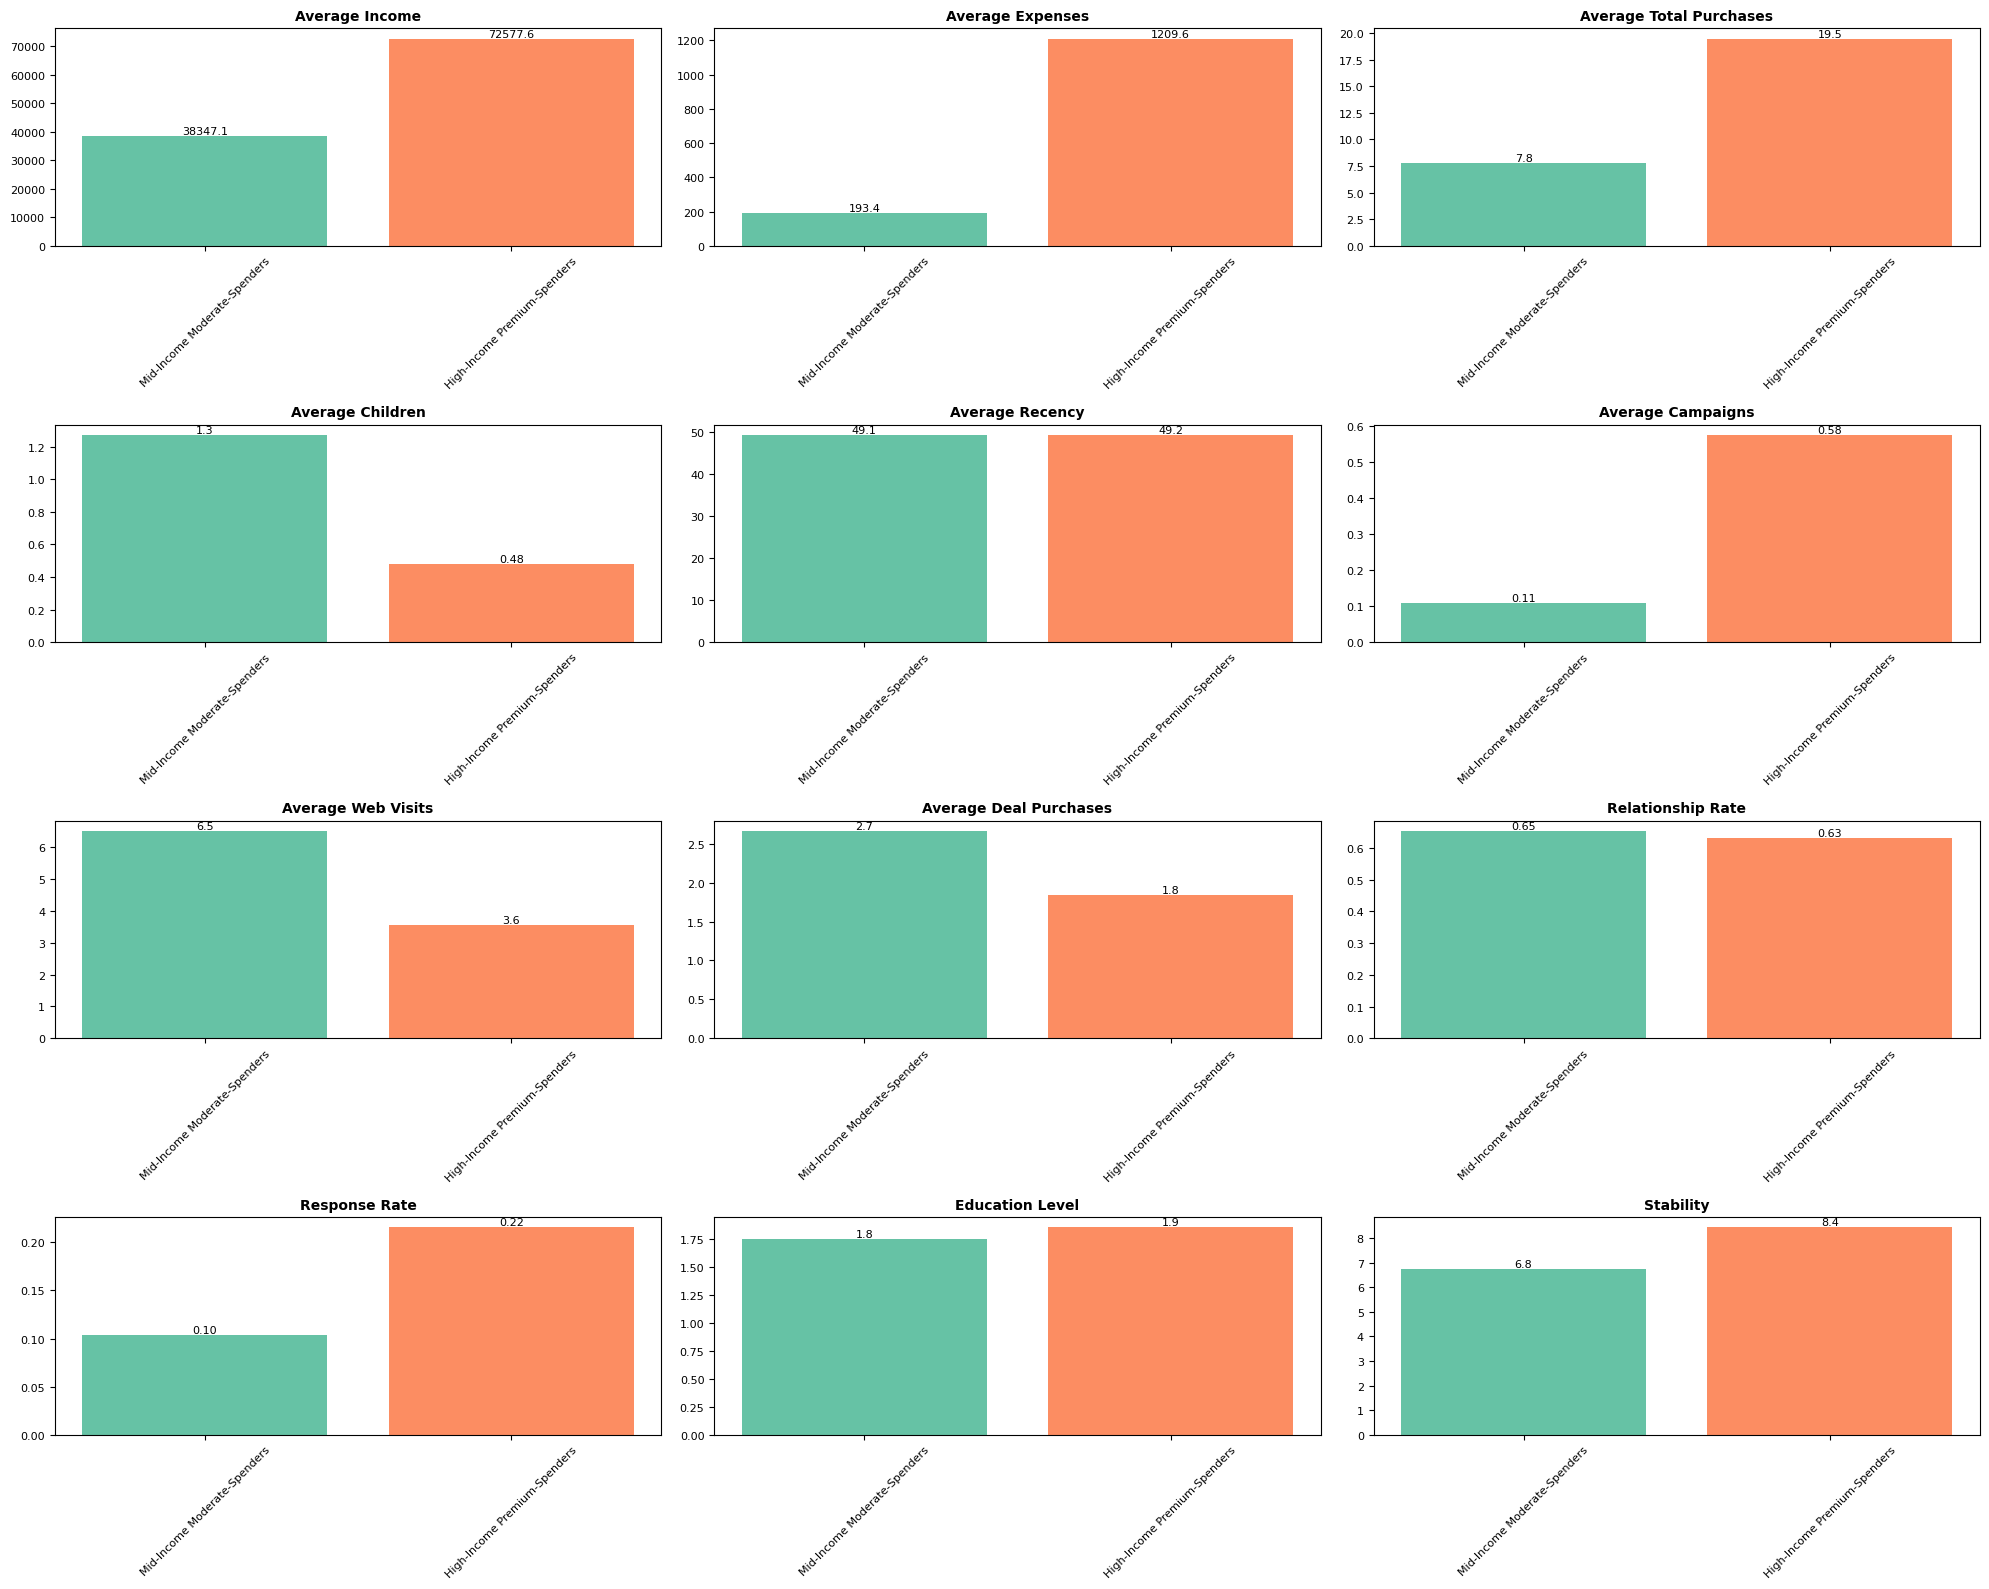

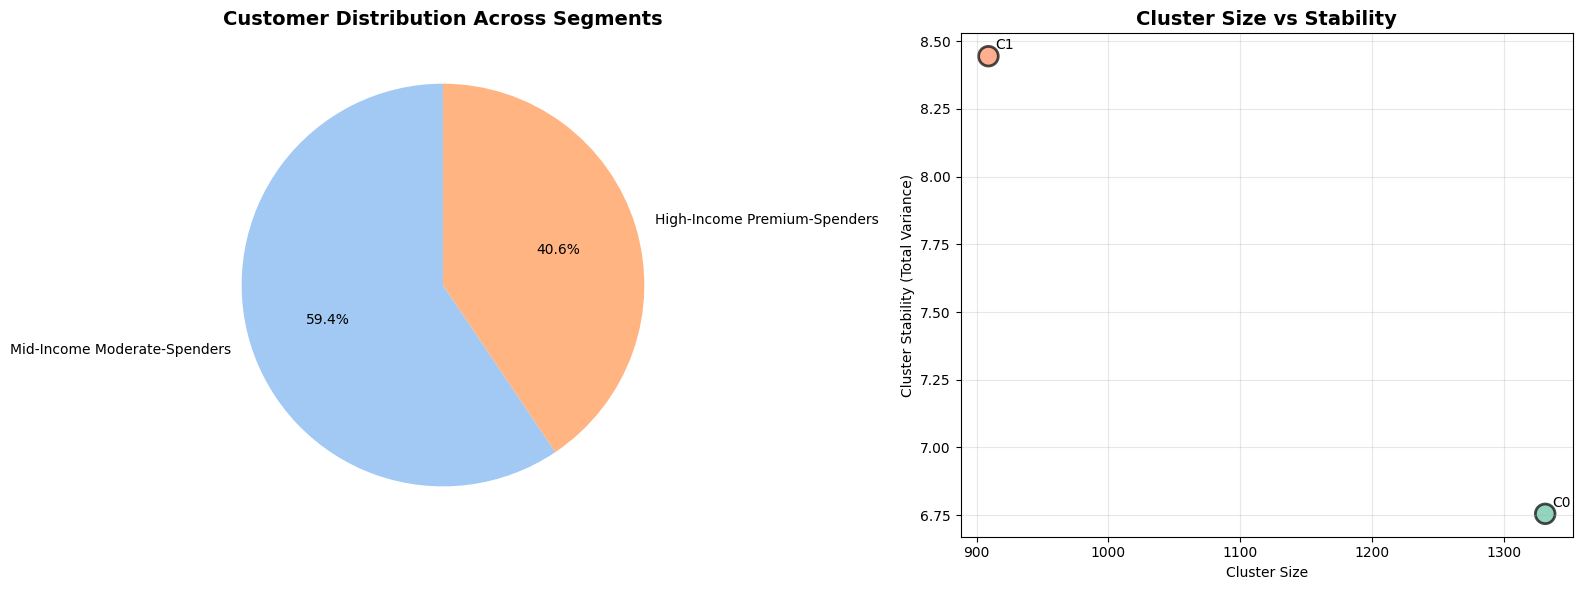


=== AGE GROUP DISTRIBUTION BY SEGMENT ===
Cluster                            0    1   All
AgeGroup                                       
Young Impulsive/Luxury (18–25)    49   42    91
Budget-Conscious (26–45)         754  390  1144
Affluent Mid-Lifers (46–65)      503  422   925
Senior Premium Buyers (65+)       23   54    77
All                             1329  908  2237


In [21]:
# 3. ENHANCED CLUSTER PROFILING WITH UNIQUE NAMING
print(f"\n=== CLUSTER PROFILING (Using {best_method} Results) ===")

# Add cluster labels to dataframe
df_analysis = df.copy()
df_analysis['Cluster'] = best_labels

# Remove noise points if any (for DBSCAN)
df_clean_analysis = df_analysis[df_analysis['Cluster'] != -1].copy()

# Calculate cluster statistics
cluster_profiles = []
for cluster in sorted(df_clean_analysis['Cluster'].unique()):
    cluster_data = df_clean_analysis[df_clean_analysis['Cluster'] == cluster]
    profile = {
        'Cluster': cluster,
        'Size': len(cluster_data),
        'Size_Percent': len(cluster_data) / len(df_clean_analysis) * 100,
        'Avg_Income': cluster_data['Income'].mean(),
        'Avg_Expenses': cluster_data['Expenses'].mean(),
        'Avg_Total_Purchases': cluster_data['Total_Purchases'].mean(),
        'Avg_Children': cluster_data['Children'].mean(),
        'Avg_Recency': cluster_data['Recency'].mean(),
        'Avg_Campaigns': cluster_data['Effective_Campaigns'].mean(),
        'Avg_Web_Visits': cluster_data['NumWebVisitsMonth'].mean(),
        'Avg_Deal_Purchases': cluster_data['NumDealsPurchases'].mean(),
        'Relationship_Rate': cluster_data['Is_In_Relationship'].mean(),
        'Response_Rate': cluster_data['Response'].mean(),
        'Education_Level': cluster_data['Education_Encoded'].mean()
    }
    cluster_profiles.append(profile)

# Create profile dataframe
profile_df = pd.DataFrame(cluster_profiles)
print("Detailed Cluster Profiles:")
print(profile_df.round(2))

print("\n=== CLUSTER STABILITY ANALYSIS ===")
# Calculate within-cluster variance for each cluster
cluster_variances = {}
for cluster in sorted(df_clean_analysis['Cluster'].unique()):
    cluster_data = df_clean_analysis[df_clean_analysis['Cluster'] == cluster]
    cluster_scaled = scaler.transform(cluster_data[clustering_features])

    # Calculate variance for each feature within the cluster
    feature_variances = np.var(cluster_scaled, axis=0)
    cluster_variances[cluster] = {
        'Total_Variance': feature_variances.sum(),
        'Avg_Variance': feature_variances.mean(),
        'Max_Variance': feature_variances.max(),
        'Feature_Variances': dict(zip(clustering_features, feature_variances))
    }

print("Within-Cluster Variance Analysis:")
print("="*50)
for cluster, variance_info in cluster_variances.items():
    print(f"Cluster {cluster}:")
    print(f"  Total Variance: {variance_info['Total_Variance']:.3f}")
    print(f"  Average Variance: {variance_info['Avg_Variance']:.3f}")
    print(f"  Max Feature Variance: {variance_info['Max_Variance']:.3f}")

    # Show top 3 most variable features within cluster
    feature_vars = variance_info['Feature_Variances']
    top_variable_features = sorted(feature_vars.items(), key=lambda x: x[1], reverse=True)[:3]
    print(f"  Most Variable Features: {', '.join([f'{feat}({var:.3f})' for feat, var in top_variable_features])}")
    print()

print("\n=== PROFILING SYSTEM ===")

# Calculate percentiles for better segmentation
income_q25, income_q50, income_q75 = df_clean_analysis['Income'].quantile([0.25, 0.5, 0.75])
expenses_q25, expenses_q50, expenses_q75 = df_clean_analysis['Expenses'].quantile([0.25, 0.5, 0.75])
campaigns_q75 = df_clean_analysis['Effective_Campaigns'].quantile(0.75)
recency_q75 = df_clean_analysis['Recency'].quantile(0.75)
purchases_q25, purchases_q75 = df_clean_analysis['Total_Purchases'].quantile([0.25, 0.75])
web_visits_q75 = df_clean_analysis['NumWebVisitsMonth'].quantile(0.75)

# Enhanced unique naming system
segment_names = {}
used_names = set()

# Sort by multiple characteristics for systematic naming
profile_sorted = profile_df.sort_values(['Avg_Expenses', 'Avg_Income'], ascending=False)

for idx, row in profile_sorted.iterrows():
    cluster = int(row['Cluster'])
    descriptors = []

    # Income level descriptors
    if row['Avg_Income'] >= income_q75:
        descriptors.append("High-Income")
    elif row['Avg_Income'] <= income_q25:
        descriptors.append("Budget")
    else:
        descriptors.append("Mid-Income")

    # Spending behavior descriptors
    if row['Avg_Expenses'] >= expenses_q75:
        if "High-Income" in descriptors:
            descriptors.append("Premium-Spenders")
        else:
            descriptors.append("High-Spenders")
    elif row['Avg_Expenses'] <= expenses_q25:
        descriptors.append("Conservative-Spenders")
    else:
        descriptors.append("Moderate-Spenders")

    # Engagement level descriptors
    if row['Avg_Campaigns'] >= campaigns_q75:
        descriptors.append("Campaign-Active")
    elif row['Avg_Campaigns'] == 0:
        descriptors.append("Campaign-Resistant")

    # Activity level descriptors
    if row['Avg_Recency'] >= recency_q75:
        descriptors.append("Inactive")
    elif row['Avg_Total_Purchases'] >= purchases_q75:
        descriptors.append("Frequent-Buyers")
    elif row['Avg_Web_Visits'] >= web_visits_q75 and row['Avg_Total_Purchases'] <= purchases_q25:
        descriptors.append("Browsers")

    # Create unique name by combining top descriptors
    if len(descriptors) >= 2:
        # Take most distinctive descriptors
        name = f"{descriptors[0]} {descriptors[1]}"
    else:
        name = descriptors[0] if descriptors else f"Standard-Customers"

    segment_names[cluster] = name

# Add segment names to profile
profile_df['Segment_Name'] = profile_df['Cluster'].map(segment_names)

print("="*40)

for cluster, name in sorted(segment_names.items()):
    size = profile_df[profile_df['Cluster']==cluster]['Size'].iloc[0]
    avg_income = profile_df[profile_df['Cluster']==cluster]['Avg_Income'].iloc[0]
    avg_expenses = profile_df[profile_df['Cluster']==cluster]['Avg_Expenses'].iloc[0]
    stability = cluster_variances[cluster]['Total_Variance']

    print(f"🎯 Cluster {cluster}: {name}")
    print(f"   Size: {size} customers ({size/len(df_clean_analysis)*100:.1f}%)")
    print(f"   Avg Income: ${avg_income:,.0f} | Avg Expenses: ${avg_expenses:,.0f}")
    print(f"   Stability: {stability:.3f} (lower = more stable)")
    print()

print("\n=== COMPREHENSIVE CLUSTER VISUALIZATION ===")

# Create enhanced profile visualizations
fig, axes = plt.subplots(4, 3, figsize=(20, 16))
axes = axes.ravel()

# Metrics to visualize
metrics = ['Avg_Income', 'Avg_Expenses', 'Avg_Total_Purchases',
          'Avg_Children', 'Avg_Recency', 'Avg_Campaigns',
          'Avg_Web_Visits', 'Avg_Deal_Purchases', 'Relationship_Rate',
          'Response_Rate', 'Education_Level']

# Add stability metric
stability_data = [cluster_variances[cluster]['Total_Variance'] for cluster in sorted(profile_df['Cluster'])]
profile_df['Stability'] = stability_data
metrics.append('Stability')

colors = sns.color_palette("Set2", len(profile_df))

for idx, metric in enumerate(metrics):
    bars = axes[idx].bar(profile_df['Segment_Name'], profile_df[metric], color=colors)
    axes[idx].set_title(f'{metric.replace("Avg_", "Average ").replace("_", " ")}',
                       fontweight='bold', fontsize=10)
    axes[idx].tick_params(axis='x', rotation=45, labelsize=8)
    axes[idx].tick_params(axis='y', labelsize=8)

    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        axes[idx].text(bar.get_x() + bar.get_width()/2., height,
                     f'{height:.1f}' if height > 1 else f'{height:.2f}',
                     ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

# Enhanced distribution visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Pie chart for customer distribution
segment_counts = df_clean_analysis.groupby('Cluster').size()
segment_names_list = [profile_df[profile_df['Cluster']==i]['Segment_Name'].iloc[0]
                     for i in segment_counts.index]

colors_pie = sns.color_palette("pastel", len(segment_names_list))
wedges, texts, autotexts = axes[0].pie(segment_counts.values, labels=segment_names_list,
                                      autopct='%1.1f%%', startangle=90, colors=colors_pie,
                                      textprops={'fontsize': 10})
axes[0].set_title('Customer Distribution Across Segments', fontsize=14, fontweight='bold')

# Stability vs Size scatter plot
axes[1].scatter(profile_df['Size'], profile_df['Stability'], s=200,
               c=colors, alpha=0.7, edgecolors='black', linewidth=2)
for i, row in profile_df.iterrows():
    axes[1].annotate(f"C{int(row['Cluster'])}",
                    (row['Size'], row['Stability']),
                    xytext=(5, 5), textcoords='offset points', fontsize=10)
axes[1].set_xlabel('Cluster Size')
axes[1].set_ylabel('Cluster Stability (Total Variance)')
axes[1].set_title('Cluster Size vs Stability', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Age group analysis by cluster
print("\n=== AGE GROUP DISTRIBUTION BY SEGMENT ===")
age_cluster_analysis = pd.crosstab(df_clean_analysis['AgeGroup'],
                                  df_clean_analysis['Cluster'], margins=True)
print(age_cluster_analysis)

Features for prediction: ['Income', 'Recency', 'NumDealsPurchases', 'NumWebVisitsMonth', 'Children', 'Expenses', 'Effective_Campaigns', 'Total_Purchases', 'Is_In_Relationship', 'Education_Encoded']
Target distribution:
Cluster
0    1331
1     909
Name: count, dtype: int64

=== TRAINING CLASSIFICATION MODELS ===
Training set size: (1792, 10)
Test set size: (448, 10)

Training Random Forest...
Random Forest Results:
  Accuracy: 0.982
  F1-Score: 0.982

Training Logistic Regression...
Logistic Regression Results:
  Accuracy: 0.991
  F1-Score: 0.991

=== MODEL EVALUATION ===

Best Model: Logistic Regression
Best Accuracy: 0.991
Best F1-Score: 0.991

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99       266
           1       0.98      1.00      0.99       182

    accuracy                           0.99       448
   macro avg       0.99      0.99      0.99       448
weighted avg       0.99      0.

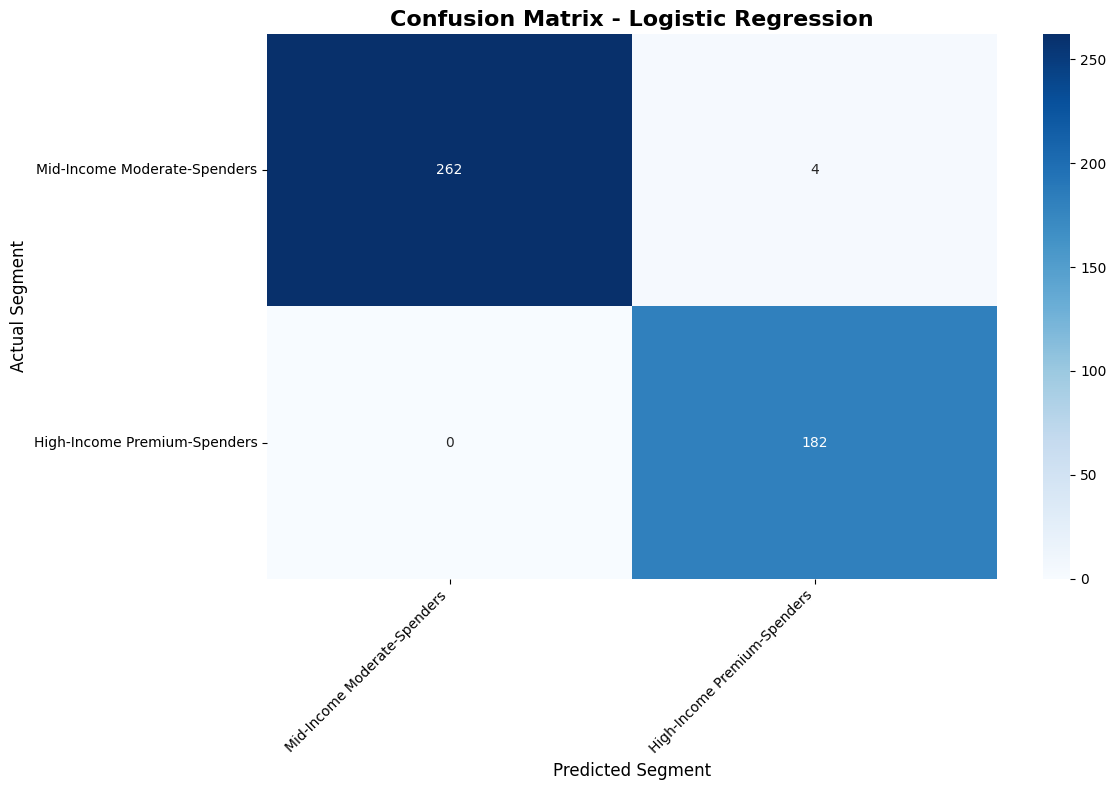

In [24]:
# 4. SUPERVISED SEGMENT PREDICTION

# Prepare features for supervised learning
supervised_features = clustering_features.copy()
# Prepare the data (use cleaned analysis data without noise points)
X_supervised = df_clean_analysis[supervised_features]
y_supervised = df_clean_analysis['Cluster']

print(f"Features for prediction: {supervised_features}")
print(f"Target distribution:\n{y_supervised.value_counts().sort_index()}")

print("\n=== TRAINING CLASSIFICATION MODELS ===")

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X_supervised, y_supervised, test_size=0.2, random_state=42, stratify=y_supervised
)

print(f"Training set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")

# Train Random Forest
print("\nTraining Random Forest...")
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=10)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)

rf_accuracy = accuracy_score(y_test, rf_pred)
rf_f1 = f1_score(y_test, rf_pred, average='weighted')

print(f"Random Forest Results:")
print(f"  Accuracy: {rf_accuracy:.3f}")
print(f"  F1-Score: {rf_f1:.3f}")

# Train Logistic Regression
print("\nTraining Logistic Regression...")
lr_model = LogisticRegression(random_state=42, max_iter=1000)
lr_model.fit(X_train, y_train)
lr_pred = lr_model.predict(X_test)

lr_accuracy = accuracy_score(y_test, lr_pred)
lr_f1 = f1_score(y_test, lr_pred, average='weighted')

print(f"Logistic Regression Results:")
print(f"  Accuracy: {lr_accuracy:.3f}")
print(f"  F1-Score: {lr_f1:.3f}")

print("\n=== MODEL EVALUATION ===")

# Choose best model
if rf_accuracy >= lr_accuracy:
    best_model = rf_model
    best_pred = rf_pred
    model_name = "Random Forest"
    best_accuracy = rf_accuracy
    best_f1 = rf_f1
else:
    best_model = lr_model
    best_pred = lr_pred
    model_name = "Logistic Regression"
    best_accuracy = lr_accuracy
    best_f1 = lr_f1

print(f"\nBest Model: {model_name}")
print(f"Best Accuracy: {best_accuracy:.3f}")
print(f"Best F1-Score: {best_f1:.3f}")

# Detailed classification report
print(f"\n{model_name} Classification Report:")
print(classification_report(y_test, best_pred))

# Confusion Matrix with segment names
cm = confusion_matrix(y_test, best_pred)
plt.figure(figsize=(12, 8))

# Create labels for confusion matrix
cluster_labels = sorted(segment_names.keys())
segment_labels = [segment_names[i] for i in cluster_labels]

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
           xticklabels=segment_labels, yticklabels=segment_labels)
plt.title(f'Confusion Matrix - {model_name}', fontsize=16, fontweight='bold')
plt.xlabel('Predicted Segment', fontsize=12)
plt.ylabel('Actual Segment', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Feature Importance (for Random Forest)
if model_name == "Random Forest":
    print(f"\n=== FEATURE IMPORTANCE ({model_name}) ===")
    feature_importance = pd.DataFrame({
        'Feature': supervised_features,
        'Importance': best_model.feature_importances_
    }).sort_values('Importance', ascending=False)

    print("Top Features for Segmentation:")
    print(feature_importance.round(4))

    # Plot feature importance
    plt.figure(figsize=(12, 8))
    sns.barplot(data=feature_importance, y='Feature', x='Importance', palette='viridis')
    plt.title('Feature Importance for Customer Segmentation', fontweight='bold', fontsize=14)
    plt.xlabel('Feature Importance')
    plt.tight_layout()
    plt.show()


=== PREDICTING NEW CUSTOMER SEGMENTS ===
Sample new customers (ORIGINAL format):
   Year_Birth   Education Marital_Status  Income  MntWines
0        1985  Graduation        Married   45000       200
1        1970         PhD         Single   85000       800
2        1995       Basic       Divorced   25000        30
3        1965      Master       Together  120000      1200

=== PREPROCESSING NEW CUSTOMERS ===
Processed features:
   Income  Recency  NumDealsPurchases  NumWebVisitsMonth  Children  Expenses  \
0   45000       15                  2                  6         2       300   
1   85000       45                  1                  4         1      1500   
2   25000       80                  5                  8         0        50   
3  120000        5                  1                  3         0      2000   

   Effective_Campaigns  Total_Purchases  Is_In_Relationship  Education_Encoded  
0                    1                8                   1                  2  
1  

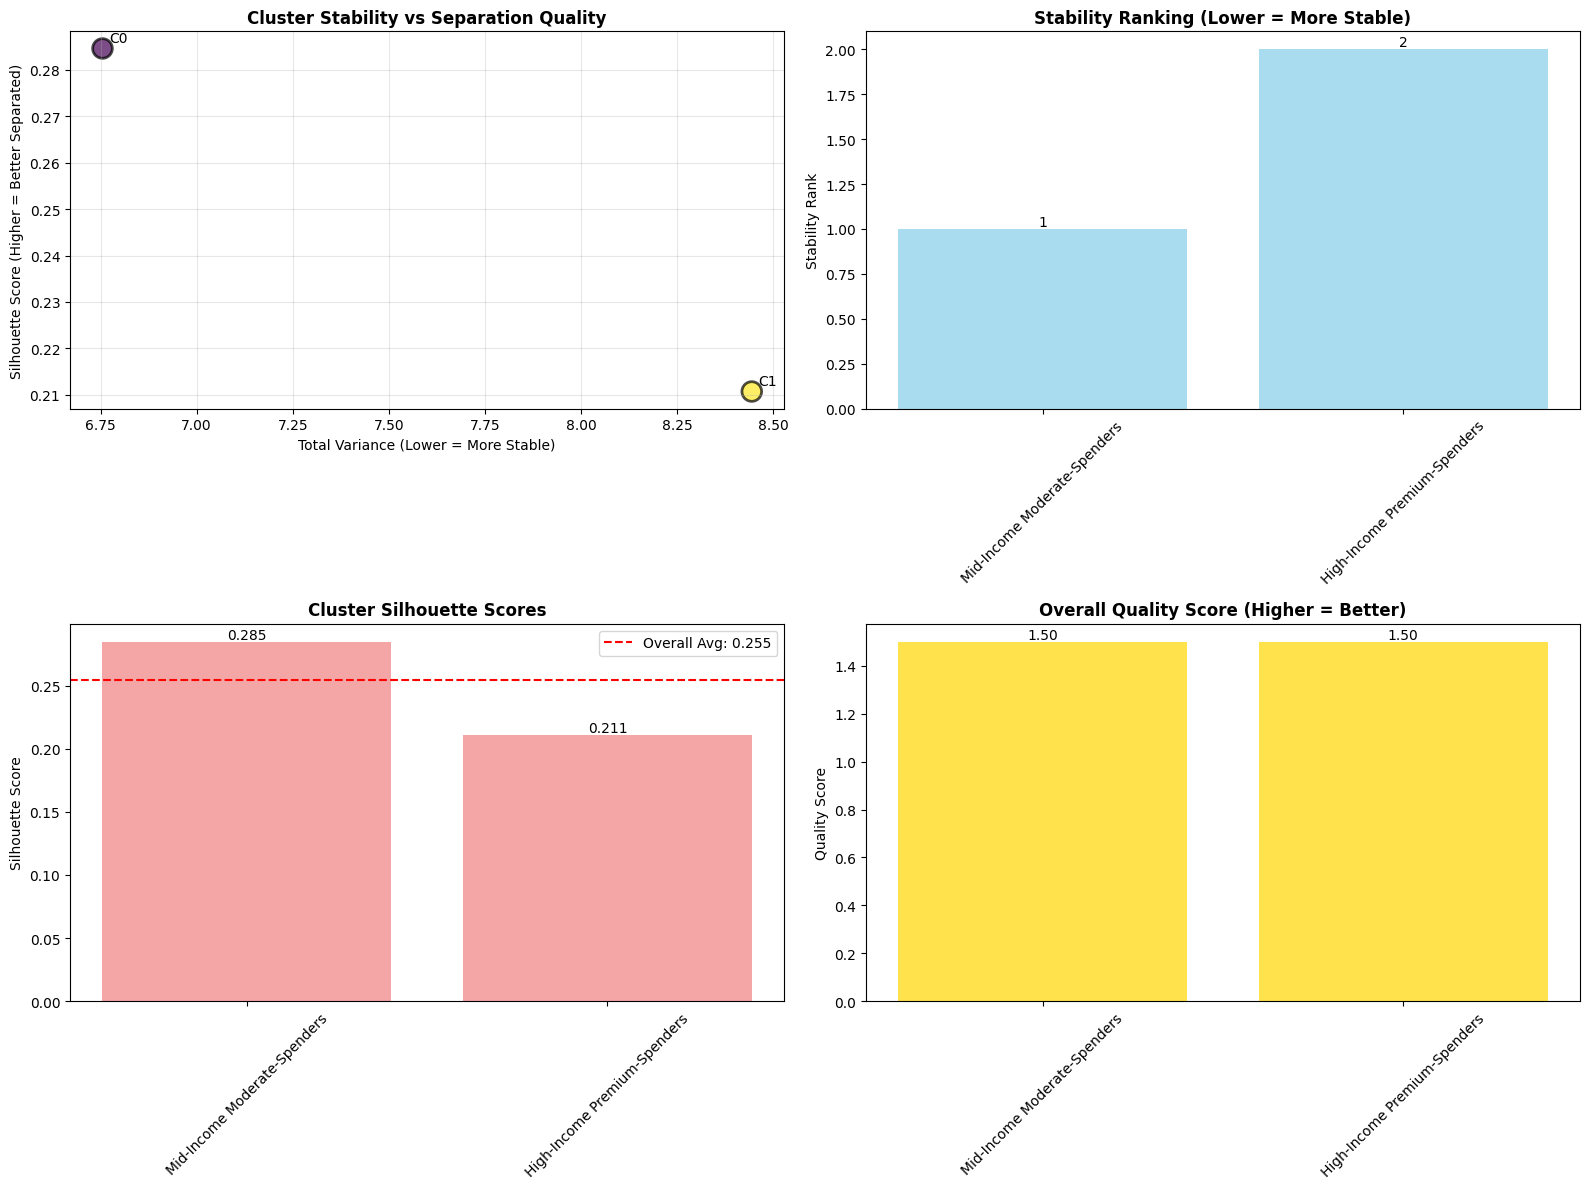


 CLUSTERING ALGORITHM COMPARISON:
 KMeans: Silhouette=0.255, Clusters=2 SELECTED
   Hierarchical: Silhouette=0.213, Clusters=2
   DBSCAN: Silhouette=0.253, Clusters=25

OPTIMAL CLUSTER CONFIGURATION:
   └─ Number of Clusters: 2
   └─ Best Algorithm: KMeans
   └─ Overall Silhouette Score: 0.255
   └─ Within-Cluster Variance: 15.200

SEGMENT PROFILES WITH STABILITY METRICS:
 Mid-Income Moderate-Spenders (Cluster 0):
   └─ Size: 1331 customers (59.4%)
   └─ Avg Income: $38,347
   └─ Avg Expenses: $193
   └─ Stability: 6.755 (Rank: 1)
   └─ Silhouette: 0.285 (Rank: 1)
   └─ Quality Score: 1.50

 High-Income Premium-Spenders (Cluster 1):
   └─ Size: 909 customers (40.6%)
   └─ Avg Income: $72,578
   └─ Avg Expenses: $1,210
   └─ Stability: 8.445 (Rank: 2)
   └─ Silhouette: 0.211 (Rank: 2)
   └─ Quality Score: 1.50

 PREDICTION MODEL PERFORMANCE:
   └─ Best Model: Logistic Regression
   └─ Accuracy: 99.1%
   └─ F1-Score: 0.991


In [27]:
print("\n=== PREDICTING NEW CUSTOMER SEGMENTS ===")

# Create sample new customers using ORIGINAL dataset format
new_customers_raw = pd.DataFrame({
    'Year_Birth': [1985, 1970, 1995, 1965],
    'Education': ['Graduation', 'PhD', 'Basic', 'Master'],
    'Marital_Status': ['Married', 'Single', 'Divorced', 'Together'],
    'Income': [45000, 85000, 25000, 120000],
    'Kidhome': [1, 0, 0, 0],
    'Teenhome': [1, 1, 0, 0],
    'Dt_Customer': ['15-01-2024', '10-12-2023', '20-02-2024', '05-11-2023'],
    'Recency': [15, 45, 80, 5],
    'MntWines': [200, 800, 30, 1200],
    'MntFruits': [30, 100, 10, 150],
    'MntMeatProducts': [50, 400, 5, 500],
    'MntFishProducts': [15, 150, 3, 100],
    'MntSweetProducts': [5, 50, 2, 50],
    'MntGoldProds': [0, 0, 0, 0],
    'NumDealsPurchases': [2, 1, 5, 1],
    'NumWebPurchases': [3, 15, 1, 20],
    'NumCatalogPurchases': [2, 8, 0, 8],
    'NumStorePurchases': [3, 2, 1, 2],
    'NumWebVisitsMonth': [6, 4, 8, 3],
    'AcceptedCmp1': [1, 0, 0, 1],
    'AcceptedCmp2': [0, 0, 0, 1],
    'AcceptedCmp3': [0, 0, 0, 1],
    'AcceptedCmp4': [0, 0, 0, 0],
    'AcceptedCmp5': [0, 0, 0, 0],
    'Complain': [0, 0, 1, 0],
    'Response': [1, 0, 0, 1]
})

print("Sample new customers (ORIGINAL format):")
print(new_customers_raw[['Year_Birth', 'Education', 'Marital_Status', 'Income', 'MntWines']])

print("\n=== PREPROCESSING NEW CUSTOMERS ===")

# Apply SAME preprocessing as training data
new_customers_processed = new_customers_raw.copy()

# Convert date and calculate reference year
new_customers_processed['Dt_Customer'] = pd.to_datetime(new_customers_processed['Dt_Customer'], format='%d-%m-%Y')
reference_year = df['Dt_Customer'].max().year

# Create derived features (same as training)
new_customers_processed['Children'] = new_customers_processed['Kidhome'] + new_customers_processed['Teenhome']
new_customers_processed['Expenses'] = (new_customers_processed['MntWines'] +
                                     new_customers_processed['MntFruits'] +
                                     new_customers_processed['MntMeatProducts'] +
                                     new_customers_processed['MntFishProducts'] +
                                     new_customers_processed['MntSweetProducts'] +
                                     new_customers_processed['MntGoldProds'])
new_customers_processed['Effective_Campaigns'] = (new_customers_processed['AcceptedCmp1'] +
                                                new_customers_processed['AcceptedCmp2'] +
                                                new_customers_processed['AcceptedCmp3'] +
                                                new_customers_processed['AcceptedCmp4'] +
                                                new_customers_processed['AcceptedCmp5'])
new_customers_processed['Total_Purchases'] = (new_customers_processed['NumWebPurchases'] +
                                             new_customers_processed['NumCatalogPurchases'] +
                                             new_customers_processed['NumStorePurchases'])

# Binary encode marital status
new_customers_processed['Is_In_Relationship'] = new_customers_processed['Marital_Status'].isin(['Married', 'Together']).astype(int)

# Encode education - map to your training categories
education_mapping = {'Basic': 0, '2n Cycle': 1, 'Graduation': 2, 'Master': 2, 'PhD': 2}
new_customers_processed['Education_Encoded'] = new_customers_processed['Education'].map(education_mapping)

# Select features for prediction
new_customers_features = new_customers_processed[supervised_features]

print("Processed features:")
print(new_customers_features)

# Make predictions
predictions = best_model.predict(new_customers_features)
prediction_proba = best_model.predict_proba(new_customers_features)

print(f"\nPredictions using {model_name}:")
for i, pred in enumerate(predictions):
    segment_name = segment_names[pred]
    confidence = prediction_proba[i][pred] * 100

    print(f"\nCustomer {i+1}: {segment_name} (Cluster {pred})")
    print(f"  Confidence: {confidence:.1f}%")
    print(f"  Original: Birth={new_customers_raw.iloc[i]['Year_Birth']}, "
          f"Income=${new_customers_raw.iloc[i]['Income']:,}, "
          f"Status={new_customers_raw.iloc[i]['Marital_Status']}")
    print(f"  Processed: Expenses=${new_customers_features.iloc[i]['Expenses']:,}, "
          f"Purchases={new_customers_features.iloc[i]['Total_Purchases']}, "
          f"Children={new_customers_features.iloc[i]['Children']}")

# Make predictions
predictions = best_model.predict(new_customers)
prediction_proba = best_model.predict_proba(new_customers)

print(f"\nPredictions using {model_name}:")
for i, pred in enumerate(predictions):
    segment_name = segment_names[pred]
    confidence = prediction_proba[i][pred] * 100

    print(f"\nCustomer {i+1}: {segment_name} (Cluster {pred})")
    print(f"  Confidence: {confidence:.1f}%")
    print(f"  Profile: Income=${new_customers.iloc[i]['Income']:,}, "
          f"Expenses=${new_customers.iloc[i]['Expenses']:,}, "
          f"Purchases={new_customers.iloc[i]['Total_Purchases']}")

# COMPREHENSIVE STABILITY ANALYSIS
# Calculate additional stability metrics
stability_metrics = pd.DataFrame({
    'Cluster': sorted(cluster_variances.keys()),
    'Segment_Name': [segment_names[c] for c in sorted(cluster_variances.keys())],
    'Total_Variance': [cluster_variances[c]['Total_Variance'] for c in sorted(cluster_variances.keys())],
    'Avg_Variance': [cluster_variances[c]['Avg_Variance'] for c in sorted(cluster_variances.keys())],
    'Max_Variance': [cluster_variances[c]['Max_Variance'] for c in sorted(cluster_variances.keys())]
})

# Add silhouette score per cluster
cluster_silhouette_scores = {}
sample_silhouette_values = silhouette_samples(X_scaled, best_labels)

for cluster in sorted(df_clean_analysis['Cluster'].unique()):
    cluster_silhouette_values = sample_silhouette_values[best_labels == cluster]
    cluster_silhouette_scores[cluster] = cluster_silhouette_values.mean()

stability_metrics['Silhouette_Score'] = [cluster_silhouette_scores[c] for c in sorted(cluster_variances.keys())]

# Calculate stability rank (lower variance = more stable = better rank)
stability_metrics['Stability_Rank'] = stability_metrics['Total_Variance'].rank()
stability_metrics['Silhouette_Rank'] = stability_metrics['Silhouette_Score'].rank(ascending=False)

print("CLUSTER STABILITY METRICS:")
print("="*80)
print(stability_metrics.round(3))

# Visualize stability metrics
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Stability vs Silhouette Score
scatter = axes[0,0].scatter(stability_metrics['Total_Variance'],
                          stability_metrics['Silhouette_Score'],
                          s=200, c=range(len(stability_metrics)),
                          cmap='viridis', alpha=0.7, edgecolors='black', linewidth=2)
for i, row in stability_metrics.iterrows():
    axes[0,0].annotate(f"C{int(row['Cluster'])}",
                      (row['Total_Variance'], row['Silhouette_Score']),
                      xytext=(5, 5), textcoords='offset points', fontsize=10)
axes[0,0].set_xlabel('Total Variance (Lower = More Stable)')
axes[0,0].set_ylabel('Silhouette Score (Higher = Better Separated)')
axes[0,0].set_title('Cluster Stability vs Separation Quality', fontweight='bold')
axes[0,0].grid(True, alpha=0.3)

# Stability ranking
bars1 = axes[0,1].bar(stability_metrics['Segment_Name'],
                     stability_metrics['Stability_Rank'],
                     color='skyblue', alpha=0.7)
axes[0,1].set_title('Stability Ranking (Lower = More Stable)', fontweight='bold')
axes[0,1].set_ylabel('Stability Rank')
axes[0,1].tick_params(axis='x', rotation=45)
for bar in bars1:
    height = bar.get_height()
    axes[0,1].text(bar.get_x() + bar.get_width()/2., height,
                  f'{int(height)}', ha='center', va='bottom')

# Silhouette score comparison
bars2 = axes[1,0].bar(stability_metrics['Segment_Name'],
                     stability_metrics['Silhouette_Score'],
                     color='lightcoral', alpha=0.7)
axes[1,0].set_title('Cluster Silhouette Scores', fontweight='bold')
axes[1,0].set_ylabel('Silhouette Score')
axes[1,0].tick_params(axis='x', rotation=45)
axes[1,0].axhline(y=best_silhouette, color='red', linestyle='--',
                 label=f'Overall Avg: {best_silhouette:.3f}')
axes[1,0].legend()
for bar in bars2:
    height = bar.get_height()
    axes[1,0].text(bar.get_x() + bar.get_width()/2., height,
                  f'{height:.3f}', ha='center', va='bottom')

# Combined quality score
quality_score = (stability_metrics['Silhouette_Rank'] +
                (len(stability_metrics) + 1 - stability_metrics['Stability_Rank'])) / 2
stability_metrics['Quality_Score'] = quality_score

bars3 = axes[1,1].bar(stability_metrics['Segment_Name'],
                     stability_metrics['Quality_Score'],
                     color='gold', alpha=0.7)
axes[1,1].set_title('Overall Quality Score (Higher = Better)', fontweight='bold')
axes[1,1].set_ylabel('Quality Score')
axes[1,1].tick_params(axis='x', rotation=45)
for bar in bars3:
    height = bar.get_height()
    axes[1,1].text(bar.get_x() + bar.get_width()/2., height,
                  f'{height:.2f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# FINAL COMPREHENSIVE SUMMARY

print("\n CLUSTERING ALGORITHM COMPARISON:")
print("="*50)
for method, result in clustering_results.items():
    silhouette = result['silhouette']
    n_clusters = len(np.unique(result['labels'][result['labels'] != -1]))
    if method == best_method:
        print(f" {method}: Silhouette={silhouette:.3f}, Clusters={n_clusters} SELECTED")
    else:
        print(f"   {method}: Silhouette={silhouette:.3f}, Clusters={n_clusters}")

print(f"\nOPTIMAL CLUSTER CONFIGURATION:")
print(f"   └─ Number of Clusters: {optimal_k}")
print(f"   └─ Best Algorithm: {best_method}")
print(f"   └─ Overall Silhouette Score: {best_silhouette:.3f}")
print(f"   └─ Within-Cluster Variance: {sum(cluster_variances[c]['Total_Variance'] for c in cluster_variances):.3f}")

print("\nSEGMENT PROFILES WITH STABILITY METRICS:")
print("="*60)
for _, row in stability_metrics.iterrows():
    cluster = int(row['Cluster'])
    name = row['Segment_Name']
    size = profile_df[profile_df['Cluster']==cluster]['Size'].iloc[0]
    percentage = profile_df[profile_df['Cluster']==cluster]['Size_Percent'].iloc[0]
    avg_income = profile_df[profile_df['Cluster']==cluster]['Avg_Income'].iloc[0]
    avg_expenses = profile_df[profile_df['Cluster']==cluster]['Avg_Expenses'].iloc[0]

    print(f" {name} (Cluster {cluster}):")
    print(f"   └─ Size: {size} customers ({percentage:.1f}%)")
    print(f"   └─ Avg Income: ${avg_income:,.0f}")
    print(f"   └─ Avg Expenses: ${avg_expenses:,.0f}")
    print(f"   └─ Stability: {row['Total_Variance']:.3f} (Rank: {int(row['Stability_Rank'])})")
    print(f"   └─ Silhouette: {row['Silhouette_Score']:.3f} (Rank: {int(row['Silhouette_Rank'])})")
    print(f"   └─ Quality Score: {row['Quality_Score']:.2f}")
    print()

print(f" PREDICTION MODEL PERFORMANCE:")
print(f"   └─ Best Model: {model_name}")
print(f"   └─ Accuracy: {best_accuracy:.1%}")
print(f"   └─ F1-Score: {best_f1:.3f}")

if model_name == "Random Forest":
    top_feature = feature_importance.iloc[0]['Feature']
    top_importance = feature_importance.iloc[0]['Importance']
    print(f"   └─ Most Important Feature: {top_feature} ({top_importance:.3f})")